# Data preparation
- 1. Preprocessing
     - ตัดคำแยกเป็น : LastName, Prefix. name
     - แยก column เป็น : prefix_name, last_name, name
     - นับจำนวน : word_lastName, syllable_lastName, word_name,syllable_name
- 2. label encoding : prefix_name_, word_lastName_, syllable_lastname_, word_name_, syllable_name_
- 3. Normalizationให้ค่ามีscaleระหว่าง 0-1 : prefix_name_, word_last_name_, syllable_lastname_, word_name_, syllable_name_

### โค้ด python function สำหรับนับพยางค์(syllables)

In [182]:
import re
def syllables(word) :
    word = word.lower()

    # exception_add are words that need extra syllables
    # exception_del are words that need less syllables

    exception_add = ['serious','crucial']
    exception_del = ['fortunately','unfortunately']

    co_one = ['cool','coach','coat','coal','count','coin','coarse','coup','coif','cook','coign','coiffe','coof','court']
    co_two = ['coapt','coed','coinci']

    pre_one = ['preach']

    syls = 0 #added syllable number
    disc = 0 #discarded syllable number

    #1) if letters < 3 : return 1
    if len(word) <= 3 :
        syls = 1
        return syls

    #2) if doesn't end with "ted" or "tes" or "ses" or "ied" or "ies", discard "es" and "ed" at the end.
    # if it has only 1 vowel or 1 set of consecutive vowels, discard. (like "speed", "fled" etc.)

    if word[-2:] == "es" or word[-2:] == "ed" :
        doubleAndtripple_1 = len(re.findall(r'[eaoui][eaoui]',word))
        if doubleAndtripple_1 > 1 or len(re.findall(r'[eaoui][^eaoui]',word)) > 1 :
            if word[-3:] == "ted" or word[-3:] == "tes" or word[-3:] == "ses" or word[-3:] == "ied" or word[-3:] == "ies" :
                pass
            else :
                disc+=1

    #3) discard trailing "e", except where ending is "le"  

    le_except = ['whole','mobile','pole','male','female','hale','pale','tale','sale','aisle','whale','while']

    if word[-1:] == "e" :
        if word[-2:] == "le" and word not in le_except :
            pass

        else :
            disc+=1

    #4) check if consecutive vowels exists, triplets or pairs, count them as one.

    doubleAndtripple = len(re.findall(r'[eaoui][eaoui]',word))
    tripple = len(re.findall(r'[eaoui][eaoui][eaoui]',word))
    disc+=doubleAndtripple + tripple

    #5) count remaining vowels in word.
    numVowels = len(re.findall(r'[eaoui]',word))

    #6) add one if starts with "mc"
    if word[:2] == "mc" :
        syls+=1

    #7) add one if ends with "y" but is not surrouned by vowel
    if word[-1:] == "y" and word[-2] not in "aeoui" :
        syls +=1

    #8) add one if "y" is surrounded by non-vowels and is not in the last word.

    for i,j in enumerate(word) :
        if j == "y" :
            if (i != 0) and (i != len(word)-1) :
                if word[i-1] not in "aeoui" and word[i+1] not in "aeoui" :
                    syls+=1

    #9) if starts with "tri-" or "bi-" and is followed by a vowel, add one.

    if word[:3] == "tri" and word[3] in "aeoui" :
        syls+=1

    if word[:2] == "bi" and word[2] in "aeoui" :
        syls+=1

    #10) if ends with "-ian", should be counted as two syllables, except for "-tian" and "-cian"

    if word[-3:] == "ian" : 
    #and (word[-4:] != "cian" or word[-4:] != "tian") :
        if word[-4:] == "cian" or word[-4:] == "tian" :
            pass
        else :
            syls+=1

    #11) if starts with "co-" and is followed by a vowel, check if exists in the double syllable dictionary, if not, check if in single dictionary and act accordingly.

    if word[:2] == "co" and word[2] in 'eaoui' :

        if word[:4] in co_two or word[:5] in co_two or word[:6] in co_two :
            syls+=1
        elif word[:4] in co_one or word[:5] in co_one or word[:6] in co_one :
            pass
        else :
            syls+=1

    #12) if starts with "pre-" and is followed by a vowel, check if exists in the double syllable dictionary, if not, check if in single dictionary and act accordingly.

    if word[:3] == "pre" and word[3] in 'eaoui' :
        if word[:6] in pre_one :
            pass
        else :
            syls+=1

    #13) check for "-n't" and cross match with dictionary to add syllable.

    negative = ["doesn't", "isn't", "shouldn't", "couldn't","wouldn't"]

    if word[-3:] == "n't" :
        if word in negative :
            syls+=1
        else :
            pass   

    #14) Handling the exceptional words.

    if word in exception_del :
        disc+=1

    if word in exception_add :
        syls+=1     

    # calculate the output
    return numVowels - disc + syls

# 1. สำหรับ Preprocessing

In [183]:
# import library
from nltk.tokenize import WhitespaceTokenizer
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from  sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler as Scaler # Normalization 0-1 เพราะ Variance มีค่าต่างกันแต่ละตัวแปร

def preprocessing(X):
    
    ### 1. ตัดคำแยกเป็น : LastName, Prefix. name ###
    
    tokenized_lists = [] # สร้าง list ไว้รอเก็บ เครื่องมือตัดคำ, ค่าตำแหน่ง
    for i in range(len(X)):
        tokenized_lists.append((WhitespaceTokenizer(), i)) # เก็บ เครื่องมือตัดคำ, ค่าตำแหน่ง(ไว้ใช้ต่อไป)    
    results = []
    for tokenized, i in tokenized_lists:
        tokenized_list = tokenized.tokenize(X[i]) 
        results.append(tokenized_list) # เอาผลไว้ใน results
        
    ### 2. แยก column เป็น : last_name,prefix_name, name ###
    
    # เก็บข้อมูลลง DataFrame
    df_text = pd.DataFrame(results)  # ยังไม่ต้องระบุชื่อคอลัมน์
    # การตัดคำจะถูกแยกออกเป็นตัดแล้วได้ 1.ได้คำที่คอลัมน์ 1 พอดี 2. ไปอยู่ที่คอลัมน์ 2 แก้โดยหา idx_fail แล้วเปลี่ยน ณ index นั้นๆ
    # กำจัด missing data ด้วยการแทน str : ' '
    for i in range(len(df_text.columns)):
        df_text[i] = df_text[i].fillna(' ')
        
        
    # กรณีถ้า คอลัมน์ไม่ถึง 4 ให้สร้าง index มาเติมให้ครบ 4
    df_text.head()
    x = len(df_text.columns) # จำนวนคอลัมน์ df ที่มี
    final = 5
    for x in range(x,4):
        df_text[x] = ''
        
    Prefix_list = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.', 'Ms.', 'Major.', 'Mlle.', 'Col.', 'Capt.', 'Jonkheer.', 'Sir.', 'Lady.', 'Dona.']
    
    idx_fail = df_text[1].loc[
        
                          (df_text[1] != Prefix_list[0]) & (df_text[1]!= Prefix_list[1]) & (df_text[1] !=Prefix_list[2]) &  (df_text[1] !=Prefix_list[3]) &
                          (df_text[1] != Prefix_list[4]) & (df_text[1]!= Prefix_list[5]) & (df_text[1] !=Prefix_list[6]) &  (df_text[1] !=Prefix_list[7]) &
                          (df_text[1] != Prefix_list[8]) & (df_text[1]!= Prefix_list[9]) & (df_text[1] !=Prefix_list[10]) &  (df_text[1] !=Prefix_list[11]) &
                          (df_text[1] != Prefix_list[12]) & (df_text[1]!= Prefix_list[13]) & (df_text[1] !=Prefix_list[14]) & (df_text[1] !=Prefix_list[15])
        
                          ] 
            
    for i in idx_fail.index:
         for j in Prefix_list:
                # ตรวจดูข้อมูลแล้วเปลี่ยนให้ถูกต้องตามแต่กรณี
                if (df_text[2].loc[i] == j):
                    df_text[0].loc[i] = df_text[0].loc[i]+' '+df_text[1].loc[i] # รวมคอลัมน์ 0, 1
                    df_text[1].loc[i] = j                 # แทนที่คอลัมน์ 1 ด้วยคอลัมน์ 2
                    
                elif df_text[2].loc[i] == 'Countess.':
                    df_text[1].loc[i] = 'the Countess.' # แทนที่ the ด้วย 'the Countess.'
                    
                elif df_text[3].loc[i] == j:
                    df_text[0].loc[i] = df_text[0].loc[i]+' '+df_text[1].loc[i]+' '+ df_text[2].loc[i] # รวมคอลัมน์ 0, 1, 2
                    df_text[1].loc[i] = j          # แทนที่คอลัมน์ 2 ด้วยคอลัมน์ 3
                    
    for i in df_text.index:
        
          for j in Prefix_list:
                

            # กรณีคอลัมน์ 1 = Prefix_list , คอลัมน์ 2 = Prefix_list
                if (df_text[1].loc[i]==j) & (df_text[2].loc[i]==j):
                    df_text[2].loc[i] = ''
                    k = 2
                    for k in range(len(df_text.loc[i])-3):
                        df_text[2].loc[i] += df_text[k+3].loc[i] + ' '
            
            # กรณีคอลัมน์ 1 = Prefix_list , คอลัมน์ 3 = Prefix_list
                elif (df_text[1].loc[i]==j) & (df_text[2].loc[i]!=j) &(df_text[3].loc[i]==j):
                    df_text[2].loc[i] = ''
                    df_text[3].loc[i] = ''
                    k = 2
                    for k in range(len(df_text.loc[i])-2):
                        df_text[2].loc[i] += df_text[k+2].loc[i] + ' '
             # ทั่วไป กรณีคอลัมน์ 1 = Prefix_list  
                elif (df_text[1].loc[i]==j) & (df_text[2].loc[i]!=j) &(df_text[3].loc[i]!=j):
                    k = 2
                    for k in range(len(df_text.loc[i])-3):
                        df_text[2].loc[i] += ' ' + df_text[k+3].loc[i]
          
    # กรณีคำนำหน้าเป็น 'the Countess.'   
    if (df_text[1].loc[i]== 'the Countess.'):
        
        k = 2
        df_text[2].loc[i] = ' '
        for k in range(len(df_text.loc[i])-2):
            df_text[2].loc[i] += ' ' + df_text[k+2].loc[i]    
     
    # เก็บไว้ใน DataFrame พร้อมตั้งชื่อคอลัมน์
    column_features = ['last_name', 'prefix_name', 'name']
    i = 0    
    for feature in column_features: 
        df_text[feature] = df_text[i]
        i += 1
        
    # เลือก features ที่จะนำมาใช้
    cols = ['last_name', 'prefix_name', 'name']
    X_features = df_text[cols]
    
    # นับจำนวน : word_lastName, syllable_lastName, word_name,syllable_name                            
    tfv = TfidfVectorizer() # แบ่งคำ
    count_word_LastName = []
    # สำหรับนับจำนวนคำ word_lastName
    for i in X_features.index:
        
        text = X_features.last_name[i]
        text_list = [text]
        words = tfv.fit_transform(text_list)
        text_cut = tfv.get_feature_names()
        count_word_LastName.append(len(text_cut))
        
    # สำหรับนับจำนวนพยางค์ syllable_Lastname     
    X_features['count_word_LastName'] = count_word_LastName    
    count_syllable_LastName = []
    for i in X_features.index:
        count_syllable_LastName.append(syllables(X_features.last_name[i]))

    X_features['count_syllable_LastName'] = np.array(count_syllable_LastName)

    # สำหรับนับจำนวนคำ word_name
    count_word_Name = []
    for i in X_features.index:
        text = X_features.name[i]
        text_list = [text]
        words = tfv.fit_transform(text_list)
        text_cut = tfv.get_feature_names()
        count_word_Name.append(len(text_cut)) 
    X_features['count_word_Name'] = np.array(count_word_Name)    
    
    # สำหรับนับจำนวนพยางค์ syllable_name
    count_syllable_Name = []
    for i in X_features.index:
        count_syllable_Name.append(syllables(X_features.name[i]))
       
    X_features['count_syllable_Name'] = np.array(count_syllable_Name) 
    
    col_sel = ['prefix_name', 'count_word_LastName', 'count_syllable_LastName', 'count_word_Name', 'count_syllable_Name']
    X_pp = X_features[col_sel]
    
    return  X_pp # ค่า feature สำหรับ preprocessing  

# 2. label encoding : prefix_name_, word_lastName_, syllable_lastname_, word_name_, syllable_name_ 

In [184]:
#  label encoding
from sklearn.preprocessing import LabelEncoder

def labelEncode(data, columns):
    col_sel = []
    for i in columns:
        
#       print(i)
        lb = LabelEncoder().fit_transform(data[i])
        data[i + '_'] = lb
        col_sel.append(i+'_')
    data_label = data[col_sel]   
    return data_label 

# 3.Normalizationให้ค่ามีscaleระหว่าง 0-1 : prefix_name_, word_last_name_, syllable_lastname_, word_name_, syllable_name_ ###    

In [185]:
# feature มาทำ normalization
from sklearn.preprocessing import StandardScaler

def scaler_data(data, col_sel):
    
    X_pp = data[col_sel]
    sc = Scaler()
    X_sc = sc.fit_transform(X_pp) # Normalization 0-1
    df_sc = pd.DataFrame(X_sc, columns=data.columns) # เก็บ ที่ทำtransform แล้วลงในตัวแปร df_sc
    return df_sc


==================================##################################################################=============================================================================

# โหลดข้อมูล Training

In [405]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from  sklearn.feature_extraction.text import TfidfVectorizer

Titanic_data = 'Titanic/train.csv' # เก็บชื่อที่อยู่ไฟล์
df = pd.read_csv(Titanic_data) # โหลดไฟล์
df.head(20) # preview

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Workflow for train model

## Data preparation
0. input
1. Preprocessing data
2. Label Encoding
3. Scaling data

## Model selection
1. Train, Test sprit
2. ทำ Bar plot เทียบแต่ละ Algorithm
3. เลือก model ที่ cross val mean สูงๆ SD ต่ำๆ
  - สร้าง list model แล้ว loop ประเมินด้วย Cross Validation
  - loop ประเมินด้วย Cross Validation
  - พล็อตกราฟ boxplot เพื่อเลือก the best of algorithm
4. หาค่า parameter tuning ด้วย Grid Randomized

# Model evaluation
1. ประเมิณด้วย confusionmatrix
2. ประเมิณด้วย Accuracy, Precision, Recall และ Cross val scores 

## 0. รับข้อมูลเป็น series (input)

- เมื่อชุดข้อมูลเป็น list

- เมื่อชุดข้อมูลเป็น DataFrame

In [188]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from  sklearn.feature_extraction.text import TfidfVectorizer

Titanic_data = 'Titanic/train.csv' # เก็บชื่อที่อยู่ไฟล์
df = pd.read_csv(Titanic_data) # โหลดไฟล์
df.head() # preview
X = df.Name

## 1. Preprocessing data

In [189]:
df_text = preprocessing(X)
df_text

,prefix_name,count_word_LastName,count_syllable_LastName,count_word_Name,count_syllable_Name
0,Mr.,1,1,2,4
1,Mrs.,1,2,5,9
2,Miss.,1,3,1,2
3,Mrs.,1,3,5,7
4,Mr.,1,2,2,4
...,...,...,...,...,...
886,Rev.,1,3,1,2
887,Miss.,1,2,2,5
888,Miss.,1,2,3,8
889,Mr.,1,1,2,3


## 2. Label Encoding

In [190]:
col_sel = ['count_word_LastName', 'count_syllable_LastName', 'count_word_Name', 'count_syllable_Name','prefix_name'] # คอลัมน์ที่เลือกไปทำ label
data_label = labelEncode(df_text, col_sel)
data_label.tail() # data label แล้ว

,count_word_LastName_,count_syllable_LastName_,count_word_Name_,count_syllable_Name_,prefix_name_
886,0,2,0,1,14
887,0,1,1,4,8
888,0,1,2,7,8
889,0,0,1,2,11
890,0,1,0,1,11


## 3. Scaling data

In [191]:
col_sel = ['count_word_LastName_', 'count_syllable_LastName_', 'count_word_Name_', 'count_syllable_Name_','prefix_name_']
data_scaled = scaler_data(data_label, col_sel)
data_scaled # data scale แล้ว

,count_word_LastName_,count_syllable_LastName_,count_word_Name_,count_syllable_Name_,prefix_name_
0,0.0,0.000000,0.166667,0.200000,0.6875
1,0.0,0.166667,0.666667,0.533333,0.7500
2,0.0,0.333333,0.000000,0.066667,0.5000
3,0.0,0.333333,0.666667,0.400000,0.7500
4,0.0,0.166667,0.166667,0.200000,0.6875
...,...,...,...,...,...
886,0.0,0.333333,0.000000,0.066667,0.8750
887,0.0,0.166667,0.166667,0.266667,0.5000
888,0.0,0.166667,0.333333,0.466667,0.5000
889,0.0,0.000000,0.166667,0.133333,0.6875


# Model selection

In [192]:
# แบ่งข้อมูลเป็น train, test
# Train model อีกรอบ
X = data_scaled # features หลังผ่าน preprocessingแ
y = df.Survived # label or class สำหรับ train model

## 1.Train, Test split

In [193]:
# ทำไว้สำหรับ ทดสอบโมเดลที่ดีที่สุด
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state= 2020) # แบ่งเป็น X y test train จาก X y โดยที่ test_size = 0.2 (train_size=0.8)

## 2. ทำ Bar plot เทียบแต่ละ Algorithm

In [194]:
# ทำการ import library สร้าง list model แล้ว loop ประเมินด้วย Cross Validation
# ทำการ import library
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# สร้าง list models
models = []
models.append(('LR', LogisticRegression()))
models.append(('kNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('XGBT',XGBClassifier()))

In [195]:
#  loop ประเมินด้วย Cross Validation
from sklearn.model_selection import cross_val_score

results = []
names = []
for name, model in models:
    cvs = cross_val_score(model, X, y, cv=10)
    names.append(name) # เอาตัวแปร name ไปเก็บชื่อโมเดลจาก models
    cvs = cross_val_score(model, X, y, cv=10) # ตัวแปร model เก็บค่ามาจาก models ลำดับที่ 2 เช่น naemeเก็บ'LR' และ model เก็บ LogisticRegression()
    results.append(cvs) # เอาผล cvs ที่คำนวณได้เก็บไว้ใน results
    print('{:4} {:.4f} ({:.3f})'.format(name, cvs.mean(), cvs.std())) 

LR   0.6892 (0.041)
kNN  0.7250 (0.040)
NB   0.6678 (0.029)
SVC  0.7464 (0.034)
RFC  0.7575 (0.027)
DT   0.7475 (0.029)
XGBT 0.7564 (0.029)


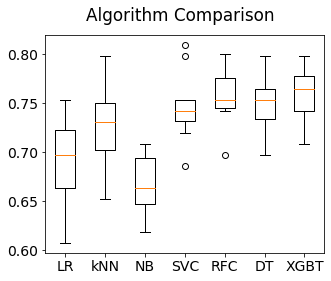

In [196]:
import matplotlib.pyplot as plt
# พล็อตกราฟ boxplot เพื่อเลือก Best of algorithm
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111) # row column id
plt.boxplot(results) # plot box plot
ax.set_xticklabels(names) # label ชื่อ แกน x
plt.show()

## 3. เลือก model ที่ cross val mean สูงๆ SD ต่ำๆ

- Algorithm ที่ดีที่สุดจาก bar plot คือ RFC
- จาก bar plot การเลือกใช้ algorithm ควรใช้ RFC(ให้ cross val score :75.42%) 

## 4. หาค่า parameter tuning ด้วย Grid Randomized

In [197]:
# bestmodel
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=440, max_features='sqrt',
                       max_leaf_nodes=9, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=440, max_features='sqrt',
                       max_leaf_nodes=9, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [198]:
from sklearn.ensemble import RandomForestClassifier
from time import time
# bestmodel
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=440, max_features='sqrt',
                       max_leaf_nodes=9, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
start = time() # เวลาเริ่มต้น train
model_RFC.fit(X_train, y_train) # Train สร้าง model
finish_RFC = time() -start
print('{:.5f} sec'.format(finish_RFC)) # เวลาเสร็จสิ้นการทำงาน
cvs = cross_val_score(model_RFC, X, y, cv=10) # k=5
cvs_RFC = cvs.mean()*100
print('Cross val scores {}'.format(cvs.round(4)))
print('mean {:.4f} %'.format(cvs.mean()*100))
print('Time {:.4f} s'.format(finish_RFC))

0.17901 sec
Cross val scores [0.8    0.7978 0.7416 0.764  0.7865 0.764  0.7191 0.7416 0.7865 0.6742]
mean 75.7528 %
Time 0.1790 s


In [199]:
from sklearn.externals import joblib

# save model RFC_The_best_model
joblib.dump(model_RFC,'RFC_The_best_model.pkl')

['RFC_The_best_model.pkl']

# Model evaluation

1. ประเมิณด้วย confusion matrix

In [200]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#ตรวจสอบจำนวนข้อมูลที่ Train, Test และดูข้อมูลที่ใช้ Test (จะเกิดการสุ่ม)
print('Total X: {}'.format(len(X)))
print('Total train: {}'.format(len(X_train)))
print('Total test: {}'.format(len(X_test)))
X_test
# ทำการ Test
y_predict = model_RFC.predict(X_test)
y_pred = y_predict # กำหนดให้ yที่ทำนายได้ คือ y_pred
y_true = y_test # กำหนดให้ yที่ทดสอบ คือ y_true
#แยก ทำ target
class_names = ['unsurvived', 'survived']
# คำนวณรายงาน และ Confusion Matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


print('Score : {:.3f}'.format(model_RFC.score(X_test,y_test)))
print('Accuracy Score:',accuracy_score(y_test, y_pred).round(3))
# class_names no,yes จากก่อนหน้านี้
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Total X: 891
Total train: 712
Total test: 179
Score : 0.737
Accuracy Score: 0.737
              precision    recall  f1-score   support

  unsurvived       0.76      0.80      0.78       105
    survived       0.70      0.65      0.67        74

    accuracy                           0.74       179
   macro avg       0.73      0.72      0.73       179
weighted avg       0.74      0.74      0.74       179

[[84 21]
 [26 48]]


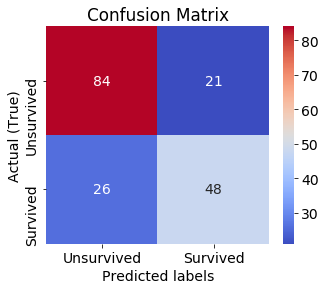

In [201]:
# ใช้ Seaborn Heat Map
import matplotlib.pyplot as plt
import seaborn as sns

ax = plt.subplot()
plt.rcParams['figure.figsize'] = 5,4  # ขนาด
plt.rcParams.update({'font.size':14})  # ความสูงอักษร

cm = confusion_matrix(y_true, y_pred) # คำนวณค่า Confusion Matrix

# กราฟ heatmap เฉดสีออกโทน ฟ้า แดง
sns.heatmap(cm, annot=True, ax=ax, cmap="coolwarm")
y_targets = ['Unsurvived', 'Survived'] # Label กำกับ ถ้าไม่มีกำหนด จะแสดง 0 1
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual (True)');
ax.set_title('Confusion Matrix'); # title
ax.xaxis.set_ticklabels(y_targets) # label กำกับแกน x
ax.yaxis.set_ticklabels(y_targets) # label กำกับแกน y
plt.show() 

## 2. ประเมิณด้วย Accuracy, Precision, Recall และ Cross val scores 

In [202]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(model, X, y, cv= 10)
# ค่า confusion matrix ต่างๆคือ
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]
TN, FP, FN, TP

precision_p = TP/(TP+FP)
precision_n = TN/(TN+FN)
recall_p = TP/(TP+FN)
recall_n = TN/(TN+FP)
accuracy = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy:', (accuracy*100).round(2),'%')
print('Precision (Positive or survived):', precision_p.round(2))
print('Precision (Negative or unsurvived):',precision_n.round(2))
print('Recall (Positive or survived):', recall_p.round(2))
print('Recall (Negative or unsurvived):', recall_n.round(2))
print('Cross val scores {}'.format(cvs.round(4)))
print('mean {:.4f}%'.format(cvs.mean()*100))  

Accuracy: 73.74 %
Precision (Positive or survived): 0.7
Precision (Negative or unsurvived): 0.76
Recall (Positive or survived): 0.65
Recall (Negative or unsurvived): 0.8
Cross val scores [0.7778 0.764  0.7079 0.7978 0.7865 0.764  0.7416 0.7753 0.7416 0.7079]
mean 75.6429%


# Data pipeline
## กรณี คำนวณหลายๆ คนพร้อมกัน
- 1.Data Preprocessing
- 2.label Encoding
- 3.model_RFC predict X_test
- 4.Display

## 1.Data Preprocessing

- คำนวณ 3 คน
- แบบกรอกชื่อเอง
- Lastname, prefix. Name

- คำนวณ 3 คน
- แบบ import datafarm มา
- Lastname, prefix. Name

In [525]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from  sklearn.feature_extraction.text import TfidfVectorizer

Titanic_data = 'Titanic/train.csv' # เก็บชื่อที่อยู่ไฟล์
df = pd.read_csv(Titanic_data) # โหลดไฟล์
df.head() # preview

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [526]:
X = df.Name # สำหรับ feature
y = df.Survived # สำหรับ label

In [527]:
# แบ่งข้อมูลมา X_test
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state= 2020) # แบ่งเป็น X y test train จาก X y โดยที่ test_size = 0.2 (train_size=0.8)

In [528]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [529]:
# คลุม list ให้ X_test แล้วอัดลงใส่ dataframe
df = pd.DataFrame(list(X_test), columns= ['Name'])
df['survived_test'] = list(y_test)
df_text = preprocessing(df.Name.loc[:2])
df_text

,prefix_name,count_word_LastName,count_syllable_LastName,count_word_Name,count_syllable_Name
0,Miss.,1,2,1,3
1,Miss.,1,1,3,5
2,Mrs.,1,1,2,4


## 2.label Encoding

In [530]:
# Label Encoding for prediction
# label สำหรับ ชื่อจำนวนน้อยๆ
def label_prediction(X_encode, col):
    #col = 'prefix_name'
    label_encode = []
    columns = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.', 'Ms.', 'Major.', 'Mlle.', 'Col.', 'Capt.', 'Jonkheer.', 'Sir.', 'Lady.', 'Dona.']
    column_label = [11, 12, 8, 7, 2, 14, 3, 10, 13, 6, 9, 1, 0, 4, 15, 5, 17]
    for i in X_encode.index:
        label_encode.append((X_encode[col].loc[i], i))
        
    for prefix, idx in label_encode:
        
        for i in range(len(columns)):
            
            if prefix == columns[i]:
                X_encode[col].loc[idx] = column_label[i]
    
    return X_encode

In [531]:
# label สำหรับ ชื่อจำนวนน้อยๆ
col_sel_label = 'prefix_name' # ต้องเป็น string ชื่อคอลัมน์ที่ต้องการแปลง
data_label = label_prediction(df_text, col_sel_label)
data_label 

,prefix_name,count_word_LastName,count_syllable_LastName,count_word_Name,count_syllable_Name
0,8,1,2,1,3
1,8,1,1,3,5
2,12,1,1,2,4


In [532]:
# label ซ้ำ สำหรับคนเยอะๆ
col_sel = ['count_word_LastName', 'count_syllable_LastName', 'count_word_Name', 'count_syllable_Name','prefix_name'] # คอลัมน์ที่เลือกไปทำ label
data_label = labelEncode(df_text, col_sel)
data_label # data label แล้ว

,count_word_LastName_,count_syllable_LastName_,count_word_Name_,count_syllable_Name_,prefix_name_
0,0,1,0,0,0
1,0,0,2,2,0
2,0,0,1,1,1


## 3.model_RFC predict X_test

In [533]:
X = data_label
# โหลด model มาใช้งาน
from sklearn.externals import joblib
import numpy as np

model_load_RFC = joblib.load('RFC_The_best_model.pkl') # โหลด Model จากไฟล์ .pkl มาใช้งาน

In [534]:
# Prediction
y_predict = model_load_RFC.predict(X)

## 4.Display

In [538]:
for i in range(len(y_predict)):
    if y_predict[i] == 0 :
        print('R.I.P {} is a unsurvivor R.I.P'.format(df.Name[i]))
        if df.survived_test[i]== y_predict[i]: # ตรวจสอบว่า ผลทำนายตรงกับ test หรือไม่
            print('Result : True')
        else:
            print('Result : False')
    
    elif y_predict[i] == 1 :
        print('{} is a survivor'.format(df.Name[i])) 
        if df.survived_test[i]== y_predict[i]: # ตรวจสอบว่า ผลทำนายตรงกับ test หรือไม่
            print('Result : True')
        else:
            print('Result : False')

Cleaver, Miss. Alice is a survivor
Result : True
Yrois, Miss. Henriette ("Mrs Harbeck") is a survivor
Result : False
Ball, Mrs. (Ada E Hall) is a survivor
Result : True


- Cleaver, Miss. Alice survivor True ชีวิตจริงรอด ถูกต้องขึ้นเรืออย่างมั่นใจ
- Yrois, Miss. Henriette ("Mrs Harbeck") is a survivor False ทำนายว่ารอดชีวิต ชีวิตจริงไม่รอด ไม่ควรขึ้นเรือเป็นอย่างยิ่ง ####### เคสอันตราย
- Ball, Mrs. (Ada E Hall) is a survivor True ชีวิตจริงรอด ถูกต้องขึ้นเรืออย่างมั่นใจ

# Data pipeline
## กรณี คำนวณหลายๆ คนพร้อมกัน
- 1.Data Preprocessing
- 2.label Encoding
- 3.scaling
- 4.model_RFC predict X_test
- 5.Display

## 1. Data preprocessing

In [544]:
# คำนวณ 10 คนขึ้นไป
# ข้อมูลเราเป็น data Frame
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from  sklearn.feature_extraction.text import TfidfVectorizer

Titanic_data = 'Titanic/train.csv' # เก็บชื่อที่อยู่ไฟล์
df = pd.read_csv(Titanic_data) # โหลดไฟล์
df.head() # preview

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [545]:
X = df.Name # สำหรับ feature
y = df.Survived # สำหรับ label

In [546]:
# ทำไว้สำหรับ ทดสอบโมเดลที่ดีที่สุด
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state= 2020) # แบ่งเป็น X y test train จาก X y โดยที่ test_size = 0.2 (train_size=0.8)

In [547]:
# คลุม list ให้ X_test แล้วอัดลงใส่ dataframe
df = pd.DataFrame(list(X_test), columns= ['Name'])
df['survived_test'] = list(y_test)

# preprocessing
df_text = preprocessing(df.Name.loc[:20])
df_text

,prefix_name,count_word_LastName,count_syllable_LastName,count_word_Name,count_syllable_Name
0,Miss.,1,2,1,3
1,Miss.,1,1,3,5
2,Mrs.,1,1,2,4
3,Mrs.,1,3,2,5
4,Mr.,1,1,2,4
5,Miss.,1,4,1,3
6,Mr.,1,3,2,6
7,Mrs.,1,1,2,6
8,Mr.,1,1,1,2
9,Mrs.,1,2,4,9


## 2.Label Encoding

In [548]:
# label_predict แบบกำหนดเองใช้อัลกอริทึมเลียนแบบ ตอนtrain

In [549]:
col_sel_label = 'prefix_name' # ต้องเป็น string ชื่อคอลัมน์ที่ต้องการแปลง
data_label = label_prediction(df_text, col_sel_label)
data_label 

,prefix_name,count_word_LastName,count_syllable_LastName,count_word_Name,count_syllable_Name
0,8,1,2,1,3
1,8,1,1,3,5
2,12,1,1,2,4
3,12,1,3,2,5
4,11,1,1,2,4
5,8,1,4,1,3
6,11,1,3,2,6
7,12,1,1,2,6
8,11,1,1,1,2
9,12,1,2,4,9


In [550]:
# label ซ้ำ สำหรับคนเยอะๆ
col_sel = ['count_word_LastName', 'count_syllable_LastName', 'count_word_Name', 'count_syllable_Name','prefix_name'] # คอลัมน์ที่เลือกไปทำ label
data_label = labelEncode(df_text, col_sel)
data_label # data label แล้ว

,count_word_LastName_,count_syllable_LastName_,count_word_Name_,count_syllable_Name_,prefix_name_
0,0,1,0,1,2
1,0,0,2,3,2
2,0,0,1,2,4
3,0,2,1,3,4
4,0,0,1,2,3
5,0,3,0,1,2
6,0,2,1,4,3
7,0,0,1,4,4
8,0,0,0,0,3
9,0,1,3,5,4


## 3. Scaling 

In [475]:
col_sel = ['count_word_LastName_', 'count_syllable_LastName_', 'count_word_Name_', 'count_syllable_Name_','prefix_name_']
data_scaled = scaler_data(data_label, col_sel)
data_scaled[:20] # data scale แล้ว

,count_word_LastName_,count_syllable_LastName_,count_word_Name_,count_syllable_Name_,prefix_name_
0,0.0,0.0,0.25,0.333333,0.666667
1,0.0,0.5,1.00,0.833333,1.000000
2,0.0,1.0,0.00,0.000000,0.333333
3,0.0,1.0,1.00,0.500000,1.000000
4,0.0,0.5,0.25,0.333333,0.666667
5,0.0,0.5,0.00,0.000000,0.666667
6,0.0,1.0,0.00,0.166667,0.666667
7,0.0,0.5,0.25,0.333333,0.000000
8,0.0,0.5,0.75,1.000000,1.000000
9,0.0,0.5,0.50,0.666667,1.000000


## 4.model_RFC predict X_test

In [551]:
X = data_label
# โหลด model มาใช้งาน
from sklearn.externals import joblib
import numpy as np

model_load_RFC = joblib.load('RFC_The_best_model.pkl') # โหลด Model จากไฟล์ .pkl มาใช้งาน
# Prediction
y_predict = model_load_RFC.predict(X)

## 5. Display

In [553]:
for i in range(len(y_predict)):
    if y_predict[i] == 0 :
        print('R.I.P {} is a unsurvivor R.I.P'.format(df.Name[i]))
        if df.survived_test[i]== y_predict[i]:
            print('Result : True')
        else:
            print('Result : False')
        
    elif y_predict[i] == 1 :
        print('{} is a survivor'.format(df.Name[i]))
        if df.survived_test[i]== y_predict[i]:
            print('Result : True')
        else:
            print('Result : False')

Cleaver, Miss. Alice is a survivor
Result : True
Yrois, Miss. Henriette ("Mrs Harbeck") is a survivor
Result : False
Ball, Mrs. (Ada E Hall) is a survivor
Result : True
Lemore, Mrs. (Amelia Milley) is a survivor
Result : True
Stead, Mr. William Thomas is a survivor
Result : False
Oreskovic, Miss. Marija is a survivor
Result : False
Foreman, Mr. Benjamin Laventall is a survivor
Result : False
Nye, Mrs. (Elizabeth Ramell) is a survivor
Result : True
R.I.P Vovk, Mr. Janko is a unsurvivor R.I.P
Result : True
Renouf, Mrs. Peter Henry (Lillian Jefferys) is a survivor
Result : True
Fortune, Miss. Mabel Helen is a survivor
Result : True
Reuchlin, Jonkheer. John George is a survivor
Result : False
Sage, Mr. George John Jr is a survivor
Result : False
Johnson, Master. Harold Theodor is a survivor
Result : True
Yasbeck, Mrs. Antoni (Selini Alexander) is a survivor
Result : True
Johnson, Miss. Eleanor Ileen is a survivor
Result : True
R.I.P McCoy, Miss. Agnes is a unsurvivor R.I.P
Result : False
R